### Load libaries

In [3]:
import tensorflow as tf
import hls4ml
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import json
%matplotlib inline

### Load the data and transform

In [4]:
data = fetch_openml('hls4ml_lhc_jets_hlf')
X, y = data['data'], data['target']
le = LabelEncoder()
y = le.fit_transform(y)
y = tf.keras.utils.to_categorical(y, 5)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_val = scaler.fit_transform(X_train_val)
X_test = scaler.transform(X_test)

### Train the model (note L1 regularization is good for keeping weights small/zero)
Optional to train. Otherwise, just load the model

In [5]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.regularizers import l1
def three_layer_model(Inputs, nclasses, l1Reg=0, name='model_1'):
    x = Dense(64, activation='relu', kernel_initializer='lecun_uniform', 
              name='fc1_relu', kernel_regularizer=l1(l1Reg))(Inputs)
    x = Dense(32, activation='relu', kernel_initializer='lecun_uniform', 
              name='fc2_relu', kernel_regularizer=l1(l1Reg))(x)
    x = Dense(32, activation='relu', kernel_initializer='lecun_uniform', 
              name='fc3_relu', kernel_regularizer=l1(l1Reg))(x)
    predictions = Dense(nclasses, activation='softmax', kernel_initializer='lecun_uniform', 
                        name='output_softmax', kernel_regularizer=l1(l1Reg))(x)
    model = Model(inputs=Inputs, outputs=predictions, name=name)
    return model

In [16]:
train = False
if train:
    keras_model = three_layer_model(Input(shape=X_train_val.shape[1:], name='input_1'), y_train_val.shape[1], l1Reg=0.001)
    keras_model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['acc'])
    keras_model.fit(X_train_val, y_train_val, batch_size=1024,
                    validation_split = 0.25, epochs = 30, 
                    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                                  patience=5, 
                                                                  restore_best_weights=True)])
    keras_model.save('keras_3layer.h5',save_format='h5', overwrite=True)
    keras_model.summary()
    y_keras = keras_model.predict(X_test)
else:
    keras_model = tf.keras.models.load_model('keras_3layer.h5')
    keras_model.summary()
    y_keras = keras_model.predict(X_test)

Train on 498000 samples, validate on 166000 samples
Epoch 1/30
498000/498000 [==============================] - 2s 5us/sample - loss: 1.3308 - acc: 0.6813 - val_loss: 1.0840 - val_acc: 0.7254
Epoch 2/30
498000/498000 [==============================] - 2s 3us/sample - loss: 1.0107 - acc: 0.7300 - val_loss: 0.9633 - val_acc: 0.7341
Epoch 3/30
498000/498000 [==============================] - 2s 4us/sample - loss: 0.9334 - acc: 0.7373 - val_loss: 0.9155 - val_acc: 0.7393
Epoch 4/30
498000/498000 [==============================] - 2s 4us/sample - loss: 0.8984 - acc: 0.7407 - val_loss: 0.8897 - val_acc: 0.7422
Epoch 5/30
498000/498000 [==============================] - 2s 4us/sample - loss: 0.8772 - acc: 0.7431 - val_loss: 0.8736 - val_acc: 0.7440
Epoch 6/30
498000/498000 [==============================] - 2s 4us/sample - loss: 0.8620 - acc: 0.7444 - val_loss: 0.8586 - val_acc: 0.7450
Epoch 7/30
498000/498000 [==============================] - 2s 3us/sample - loss: 0.8495 - acc: 0.7459 - val

### Create the hls4ml model and run C Simulation to get expected, quantized output

In [17]:
hls_cfg = hls4ml.utils.config_from_keras_model(keras_model, granularity='name')
hls_model = hls4ml.converters.convert_from_keras_model(keras_model, output_dir='hls4ml_keras_prj', hls_config=hls_cfg)
hls_model.compile()
y_hls4ml = hls_model.predict(X_test)

Interpreting Model
Topology:
Layer name: input_1, layer type: InputLayer
Layer name: fc1_relu, layer type: Dense
  -> Activation (relu), layer name: fc1_relu
Layer name: fc2_relu, layer type: Dense
  -> Activation (relu), layer name: fc2_relu
Layer name: fc3_relu, layer type: Dense
  -> Activation (relu), layer name: fc3_relu
Layer name: output_softmax, layer type: Dense
  -> Activation (softmax), layer name: output_softmax
Interpreting Model
Topology:
Layer name: input_1, layer type: InputLayer, current shape: [[None, 16]]
Layer name: fc1_relu, layer type: Dense, current shape: [[None, 16]]
Layer name: fc2_relu, layer type: Dense, current shape: [[None, 64]]
Layer name: fc3_relu, layer type: Dense, current shape: [[None, 32]]
Layer name: output_softmax, layer type: Dense, current shape: [[None, 32]]
Creating HLS model
Writing HLS project
Done


### Check difference between hls4ml and keras

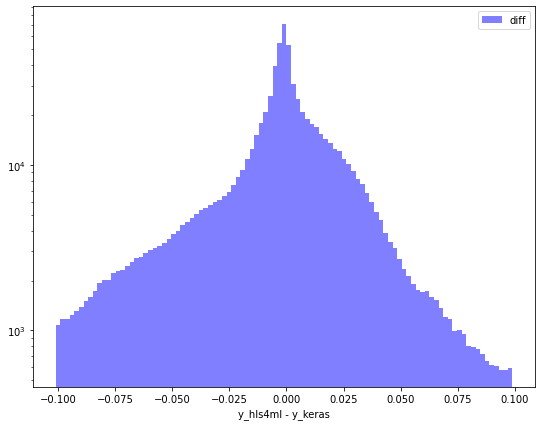

In [18]:
plt.figure(figsize=(9, 7))
h, b = np.histogram((y_hls4ml - y_keras).flatten(), bins=np.linspace(-0.1,0.1,100))
plt.bar(b[:-1], h, width=b[1]-b[0], color='b', alpha=0.5, label='diff')
plt.legend()
plt.semilogy()
plt.xlabel('y_hls4ml - y_keras')
plt.savefig('residual.png')

### Make ROC curves

Accuracy keras:  0.7498253012048193
Accuracy hls4ml: 0.7406867469879518


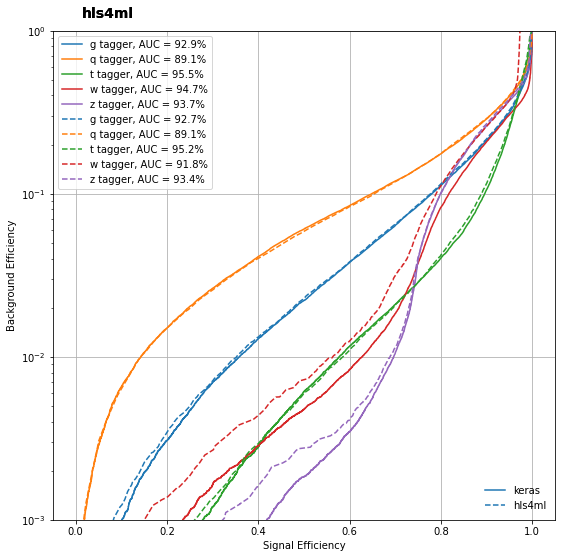

In [21]:
import plotting
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model

print("Accuracy keras:  {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))))
print("Accuracy hls4ml: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_hls4ml, axis=1))))

#ax, = plt.figure(figsize=(9, 9))
fig, ax = plt.subplots(figsize=(9, 9))
_ = plotting.makeRoc(y_test, y_keras, le.classes_)
plt.gca().set_prop_cycle(None) # reset the colors
_ = plotting.makeRoc(y_test, y_hls4ml, le.classes_, linestyle='--')

from matplotlib.lines import Line2D
lines = [Line2D([0], [0], ls='-'),
         Line2D([0], [0], ls='--')]
from matplotlib.legend import Legend
leg = Legend(ax, lines, labels=['keras', 'hls4ml'],
            loc='lower right', frameon=False)
ax.add_artist(leg)

### Run Synthesis, read resources

In [20]:
hls_model.build() # this takes a several minutes
hls4ml.report.read_vivado_report('hls4ml_keras_prj/')

Found 1 solution(s) in hls4ml_keras_prj//myproject_prj.
Reports for solution "solution1":

C SIMULATION RESULT:
INFO: [SIM 2] *************** CSIM start ***************
INFO: [SIM 4] CSIM will launch GCC as the compiler.
   Compiling ../../../../myproject_test.cpp in debug mode
   Compiling ../../../../firmware/myproject.cpp in debug mode
   Generating csim.exe
INFO: Unable to open input/predictions file, using default input.
0.0595703 0.22168 0.566406 0.0175781 0.162109 
INFO: Saved inference results to file: tb_data/csim_results.log
INFO: [SIM 1] CSim done with 0 errors.
INFO: [SIM 3] *************** CSIM finish ***************

SYNTHESIS REPORT:
== Vivado HLS Report for 'myproject'
* Date:           Fri Jul 10 10:24:10 2020

* Version:        2019.2 (Build 2704478 on Wed Nov 06 22:10:23 MST 2019)
* Project:        myproject_prj
* Solution:       solution1
* Product family: kintexu
* Target device:  xcku115-flvb2104-2-i


== Performance Estimates
+ Timing: 
    * Summary: 
    +-----